# PyGMData

Welcome to the PyGMData tutorial!

PyGMData is a Python SDK to interface with the Grey Matter Data API. It has the ability to do things like:

- Stream files directly to/from memory (both download and upload)
- Upload and download files from/to disk
- Handle impersonation and TLS connections
- File appends in Data (both from files on disk and memory)
- Internal logging, both to standard out and to a file



## Setup

First start by importing the library. This is a normal python library and can be used just the same as any other.

Then make the pygmdata object to interface with Grey Matter Data. This takes the base `URL` that Data lives at which will be used for all of the calls to Data. Optional parameters can be supplied as well. Currently these are supported:

- `USER_DN` - Used for user impersonation. This is used for every transaction if specified. This can be changed later if needed.
- `logfile` - Will ouput logs to a file if specified. No file output by default.
- `log_level` - Level of verbosity to log, defaults to warnings
- `security` - The default security policy to use. This can be overidden when writing files. If not specified it will use:
    ```Python
        {"label": "DECIPHER//GMDATA",
         "foreground": "#FFFFFF",
         "background": "green"}
    ```
- `cert` - Certificate to use in pem format.
- `key` - keyfile to use in pem format.
- `trust` - CA trust to use to make TLS connections.
- `repopulate` - A hack to get around changes that may have happened
    in Data between file uploads and hierarchy updates

In [17]:
from pygmdata import pygmdata

cert = "/Users/dborncamp/.ssh/di2e/20200831/dave.borncamp.crt"
key = "/Users/dborncamp/.ssh/di2e/20200831/dave.borncamp.key"

d = pygmdata.Data("https://mesh.greymatter.devcloud.di2e.net/services/sandbox-data/1.1",
                  cert=cert, key=key, repopulate=False)

# set a DN that has permissions to do things in Data
#d = pygmdata.Data("http://localhost:8181",
#                  USER_DN='CN=dave.borncamp,OU=Engineering,O=Untrusted Example,L=Baltimore,ST=MD,C=US')

### Create Home Directory

To start, most users will be writing to their home directory and by default it is not created for us. The PyGMData SDK has pre-built functions to create it for whatever user/imersonation is interacting with Data.

Custom Object Policies can be used for creating any directory.

In [ ]:
import json

op = '''{'label': 'email match',
 'requirements': {'f': 'if',
  'a': [{'f': 'contains',
    'a': [{'v': 'email'}, {'v': 'dave.borncamp@greymatter.io'}]},
   {'f': 'yield-all'},
   {'f': 'yield', 'a': [{'v': 'R'}, {'v': 'X'}, {'v': 'U'}]}]}}'''

d.get_self_identify(object_policy=json.loads(op))

## Writing to GM Data

### Writing to Data

Now that we have a home directory, lets start writing data into it. We'll start by uploading a file to Data from Disk

In [5]:
d.upload_file("requirements.txt", "/home/icEMail:justin.ely@ic.com/requirements.txt")

True

The text file containing the requirements for pygmdata library should now be in Data!

Lets try writing a file and streaming the contents from memory starting with a string.
Normally streaming to data would take an IO buffer, but there is a convience method for uploading strings.

In [6]:
upload_text = """This is a sample of text that is a string in memory.
It was uploaded with pygmdata.
"""

d.stream_upload_string(upload_text, '/home/icEMail:justin.ely@ic.com/DemoUpload.txt')

True

Now, lets try uploading some more interesting files like a Pandas DataFrame

In [7]:
import pandas as pd

data = {
    'name': ['Xavier', 'Ann', 'Jana', 'Yi', 'Robin', 'Amal', 'Nori'],
    'city': ['Mexico City', 'Toronto', 'Prague', 'Shanghai',
             'Manchester', 'Cairo', 'Osaka'],
    'age': [41, 28, 33, 34, 38, 31, 37],
    'py-score': [88.0, 79.0, 81.0, 80.0, 68.0, 61.0, 84.0]
}

row_labels = [1, 2, 3, 4, 5, 6, 7]

df = pd.DataFrame(data=data, index=row_labels)
df.head()

,name,city,age,py-score
1,Xavier,Mexico City,41,88.0
2,Ann,Toronto,28,79.0
3,Jana,Prague,33,81.0
4,Yi,Shanghai,34,80.0
5,Robin,Manchester,38,68.0


And now actually send it by making a buffer and converting it to a .csv and sending that output to Data

In [8]:
import io

text_stream = io.StringIO()

df.to_csv(text_stream)

d.stream_upload(text_stream, "/home/icEMail:justin.ely@ic.com/testDataFrame.csv")

True

### Append to a file

We can also append to existing files. This could be useful for adding to logs in Data. Also useful for asynchronyous writes from multiple places.

In [16]:
import time

for i in range(20):
    time.sleep(1)
    print("Appending: {}".format(i))
    d.append_data("new line {}\n".format(i), "/home/icEMail:justin.ely@ic.com/append.txt")

Appending: 0
Appending: 1
Appending: 2
Appending: 3
Appending: 4
Appending: 5
Appending: 6
Appending: 7
Appending: 8
Appending: 9
Appending: 10
Appending: 11
Appending: 12
Appending: 13
Appending: 14
Appending: 15
Appending: 16
Appending: 17
Appending: 18
Appending: 19


### Uploading WIth Rego Policy

We can also upload with any Rego/OPA policy

In [9]:
rego_string = "This is a test for the rego"

rego_policy = '''package policy
inOrg{input.claims.values.email[_]=="niprnetEmail:dave.borncamp@greymatter.io"}
R{true}
X{true}
C{inOrg}
U{inOrg}
D{inOrg}
P{inOrg}'''

d.stream_upload(rego_string, '/home/icEMail:justin.ely@ic.com/ShowRego.txt', original_object_policy=rego_policy)

True

Now look in Data and see the new file with the rego policy

### Using Actions

Now that we have som objects in Data, we can use the SDK to get information on the files. We can get the file properties (ie metadata) and list the contents of the file.

In [ ]:
from pprint import pprint

props = d.get_props('/home/icEMail:justin.ely@ic.com/ShowRego.txt')

pprint(props)

In [ ]:
listing = d.get_list('/home/icEMail:justin.ely@ic.com/')
pprint(listing)

## Reading From Grey Matter Data

Now that we have put some data up there, lets read it out. The PyGMData SDK has functions to read variables directly into memory or give buffers to be managed by other programs. 

In [ ]:
retreived_text = d.stream_file('/home/icEMail:justin.ely@ic.com/DemoUpload.txt')
print(retreived_text)

It can also stream buffers to other libraries like Pandas

In [ ]:
import pandas as pd
df1 = pd.read_csv(d.get_byte_steam('/home/icEMail:justin.ely@ic.com/testDataFrame.csv'), 
                 low_memory=False)
df1.head()

Neither of these files hit disk, they are only in memory!

PyGMData SDK also has the ability to easily download files to disk. The file is not on disk to begin with:

In [ ]:
ls

In [ ]:
d.download_file('/home/icEMail:justin.ely@ic.com/DemoUpload.txt', 'downloadTest.txt')

Now the file should be on disk and named `downloadTest.txt`

In [ ]:
ls

## Bonus Fun

We'll create some small astronomical data and centroid the sources on it, then save an annotated image without writing anything to disk.

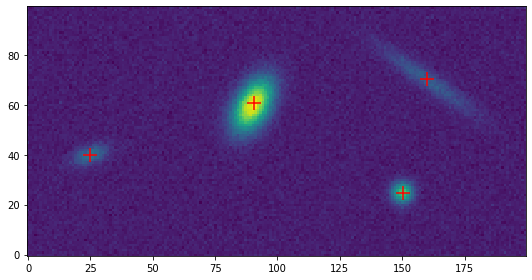

In [11]:
import io
from photutils.datasets import make_4gaussians_image
from photutils import centroid_sources, centroid_com
import matplotlib.pyplot as plt

# create 4 elongated gaussian sources and centroid
data = make_4gaussians_image()

x_init = (25, 91, 151, 160)
y_init = (40, 61, 24, 71)
x, y = centroid_sources(data, x_init, y_init, box_size=21,
                        centroid_func=centroid_com)
plt.figure(figsize=(8, 4))
plt.imshow(data, origin='lower', interpolation='nearest')
plt.scatter(x, y, marker='+', s=180, color='red')
plt.tight_layout()


# Now save the annotated plot in Data using a buffer

with io.BytesIO() as buf:
    plt.savefig(buf, format='png')
    buf.seek(0)
    d.stream_upload(buf, '/home/icEMail:justin.ely@ic.com/centroid.png')


Lets try reading the image back out

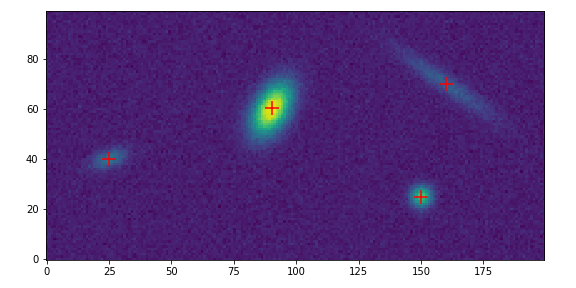

In [12]:
from PIL import Image

img = Image.open(d.get_byte_steam('/home/icEMail:justin.ely@ic.com/centroid.png'))

img

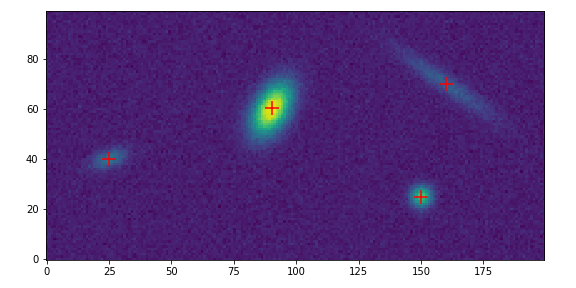

In [13]:
img1 = d.stream_file('/home/icEMail:justin.ely@ic.com/centroid.png')

img1

In [15]:
ls *.png

zsh:1: no matches found: *.png


### Supports TLS Interactions

The library also supports interactions via TLS. To demo this we will interact with a Data instance in DI2E.
Unfortunately, this is not implemented in an optimized way so initially it takes a long time when there are a lot of files in the Data instance.

In [ ]:
from importlib import reload
reload(pygmdata)
cert = "/Users/dborncamp/.ssh/di2e/20200831/dave.borncamp.crt"
key = "/Users/dborncamp/.ssh/di2e/20200831/dave.borncamp.key"

d1 = pygmdata.Data("https://mesh.greymatter.devcloud.di2e.net/services/sandbox-data/1.1",
                   cert=cert, key=key, repopulate=False, log_level='debug')

In [ ]:
d1.hierarchy

In [4]:
security={"label": "Test//GMDATA",
       "foreground": "#FFFFFF",
       "background": "green"}

In [ ]:
d1.upload_file("/Users/dborncamp/playpen/pygmdata/requirements.txt", "/home/icEMail/Test/requirements.txt", object_policy=op, security=security)

In [ ]:
target_dir = "/home/icEMail:justin.ely@ic.com"
d.get_props(target_dir)

In [ ]:
d1.upload_file("/Users/dborncamp/playpen/pygmdata/requirements.txt", "/home/icEMail:justin.ely@ic.com/requirements.txt")

In [3]:
len(d.hierarchy)

2402

In [ ]:
d.populate_hierarchy("/")

In [ ]:
from importlib import reload
reload(pygmdata)
d = pygmdata.Data("http://localhost:8181", USER_DN='CN=dave.borncamp,OU=Engineering,O=Untrusted Example,L=Baltimore,ST=MD,C=US', log_level='debug') 